# Optimal Transport with Linear Programming

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gpeyre/ot4ml/blob/main/python/1-linprog.ipynb)

This numerical tour details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming.

In [ ]:
import Pkg
Pkg.activate(".")
Pkg.add(["JuMP", "HiGHS"])
Pkg.precompile()

  Activating new project at `/content`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed HiGHS_jll ────────── v1.11.0+1
   Installed HiGHS ────────────── v1.18.1
   Installed JSON3 ────────────── v1.14.3
   Installed JuMP ─────────────── v1.26.0
   Installed CodecBzip2 ───────── v0.8.5
   Installed BenchmarkTools ───── v1.6.0
   Installed MutableArithmetics ─ v1.6.4
   Installed StructTypes ──────── v1.11.0
   Installed MathOptInterface ─── v1.42.0
    Updating `/content/Project.toml`
  [87dc4568] + HiGHS v1.18.1
  [4076af6c] + JuMP v1.26.0
    Updating `/content/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
  [523fee87] + CodecBzip2 v0.8.5
  [944b1d66] + CodecZlib v0.7.8
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.17.0
  [864edb3b] + DataStructures v0.18.22
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [ffbed154] + DocStringExtensions v0.9.5
  [f6369f11] + ForwardDiff v1.0.1
  

In [ ]:
using Random
using LinearAlgebra
using SparseArrays
using Plots
using JuMP
import HiGHS

Optimal Transport of Discrete Distributions
------------------------------------------

We consider two discrete distributions
$$
\alpha = \sum_{i=1}^n a_i \delta_{x_i} \quad \text{and} \quad
\beta = \sum_{j=1}^m b_j \delta_{y_j}.
$$

where $n, m$ are the number of points, $\delta_x$ is the Dirac at
location $x \in \mathbb{R}^d$, and $(x_i)_i$, $(y_j)_j$ are the positions of the Diracs in $\mathbb{R}^d$.

Dimensions $(n,m)$ of the clouds.

In [ ]:
n = 60
m = 80;

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.

In [ ]:
gauss(q::Int, a::Real, c::AbstractVector{<:Real}) = a .* randn(size(c,1), q) .+ c

function generate_X_Y(n, m)
    X = randn(2, n) .* .3
    Y = hcat(
            gauss(div(m, 2), .5, [0, 1.6]),
            gauss(div(m, 4), .3, [-1,-1]),
            gauss(div(m, 4), .3, [1, -1])
        )
    return X, Y
end
X, Y = generate_X_Y(n, m);

Generate the weights $a,b$.

In [ ]:
normalize(a) = a ./ sum(a)
a = normalize(rand(n))
b = normalize(rand(m));

Display the point clouds.
The size of each dot is proportional to its probability density weight.

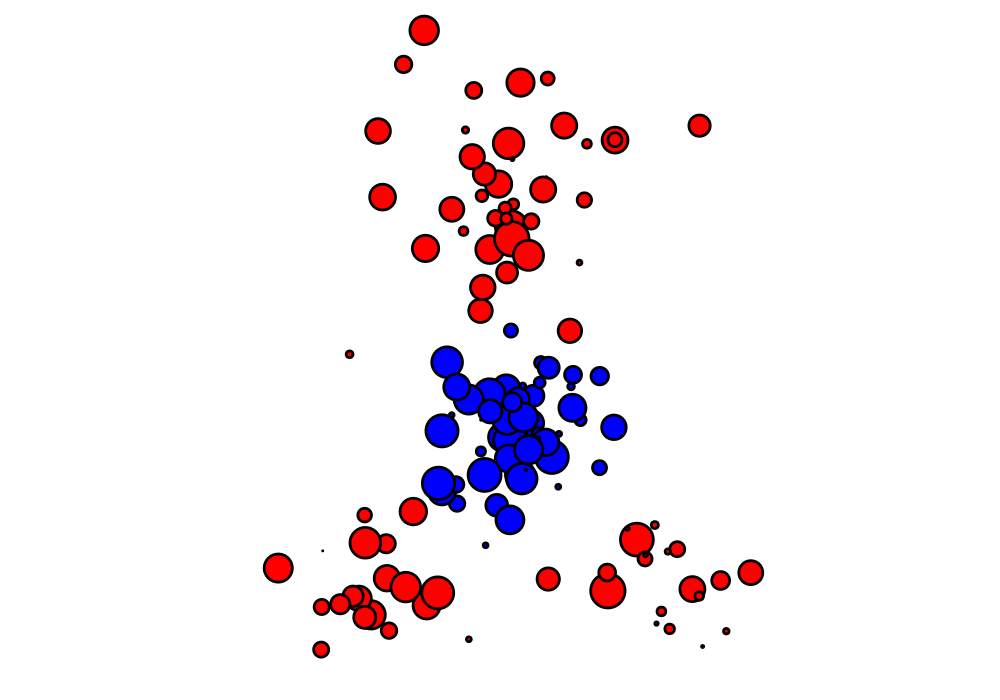

In [ ]:
function myplot!(plt, coordinates, weights, color)
    scatter!(
        plt,
        coordinates[1,:],
        coordinates[2,:],
        markersize=weights * 10,
        markercolor=color,
        markerstrokewidth=2,
        legend=false
    )
end

plt = plot(size=(10, 7).*100, aspect_ratio=:equal, border=:none)
myplot!(plt, X, a .* length(a), :blue)
myplot!(plt, Y, b .* length(b), :red)

Compute the cost matrix $C_{i,j} := \|x_i-x_j\|^2$.

In [ ]:
function distmat(x, y)
    sumsq_x = sum(abs2, x, dims=1)
    sumsq_y = sum(abs2, y, dims=1)
    return sumsq_x' .+ sumsq_y .- 2 .* x' * y
end

C = distmat(X, Y);

Initialize the JuMP optimization problem with HiGHS solver.

In [ ]:
model = Model(HiGHS.Optimizer)
set_silent(model)

Define the optimization variable $P$.

In [ ]:
@variable(model, P[1:n, 1:m] >= 0);

Define the set of discrete couplings between $\alpha$ and $\beta$ as
$$
U(a, b) := \left\{ P \in \mathbb{R}_+^{n \times m} \;\middle|\;
\forall i, \sum_j P_{i,j} = a_i, \quad
\forall j, \sum_i P_{i,j} = b_j \right\}.
$$

In [ ]:
@constraint(model, row_sums[i in 1:n], sum(P[i, j] for j in 1:m) == a[i]);
@constraint(model, col_sums[j in 1:m], sum(P[i, j] for i in 1:n) == b[j]);

The Kantorovich formulation of optimal transport reads
$$
    P^\star \in \underset{P \in U(a, b)}{\arg\min} \sum_{i,j} P_{i,j} C_{i,j}.
$$

In [ ]:
@objective(model, Min, sum(P[i, j] * C[i, j] for i in 1:n, j in 1:m))
optimize!(model)
assert_is_solved_and_feasible(model)
P_value = value.(P);

An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are never exactly 0.

In [ ]:
println("Number of non-zero: $(length(filter(x -> x>1e-5, P_value))) (n + m-1 = $(n + m-1))")

Number of non-zero: 139 (n + m-1 = 139)


Display the solution coupling.

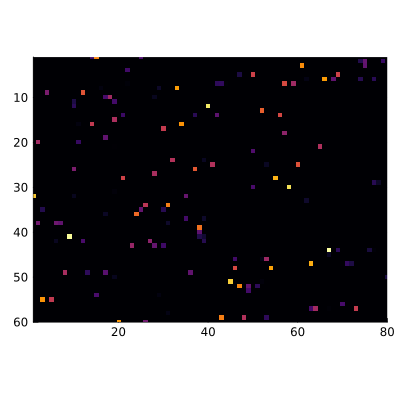

In [ ]:
heatmap(
    P_value,
    size=(400, 400),
    aspect_ratio=:equal,
    colorbar=false,
    xlim=(1,m),
    ylim=(1,n),
    yflip=true
)

Display the connexion defined by the optimal coupling.

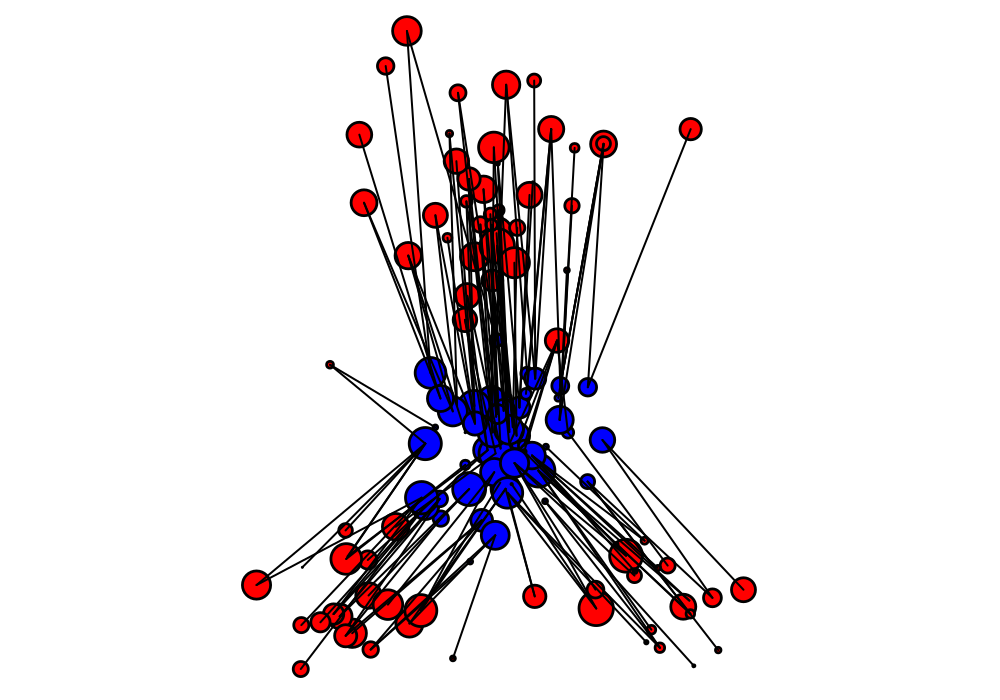

In [ ]:
# Find indices and values of non-zero couplings
non_zero_coupling(P) = map(x -> x < 1e-5 ? 0 : x, P) |> sparse |> findnz

function plot_assignments(X, Y, a, b, P)
    plt = plot(size=(1000, 700), aspect_ratio=:equal, axis=nothing, border=:none)

    I, J, _ = non_zero_coupling(P)

    myplot!(plt, X, a .* size(X, 2), :blue)
    myplot!(plt, Y, b .* size(Y, 2), :red)

    # Plot connections
    for (i, j) in zip(I, J)
        plot!(
            plt,
            [X[1, i], Y[1, j]],
            [X[2, i], Y[2, j]],
            linecolor=:black,
            linewidth=2
        )
    end

    display(plt)
end

plot_assignments(X, Y, a, b, P_value)

Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such that the map $t \mapsto \mu_t$ describes a geodesic in the Wasserstein space.

Since the $W_2$ distance is a geodesic distance, this geodesic path solves the following variational problem:
$$
\mu_t = \underset{\mu}{\arg\min} \, (1 - t) W_2(\alpha, \mu)^2 + t W_2(\beta, \mu)^2.
$$

This can be understood as a generalization of the classical Euclidean barycenter to the barycenter of probability distributions. Indeed, in the special case where $\alpha = \delta_x$ and $\beta = \delta_y$, one obtains $\mu_t = \delta_{x_t}$ with
$$
x_t = (1 - t)x + t y.
$$

Once the optimal coupling $P^\star$ has been computed, the interpolated distribution is given by
$$
\mu_t = \sum_{i,j} P^\star_{i,j} \, \delta_{(1 - t)x_i + t y_j}.
$$

Find the $i,j$ with non-zero $P_{i,j}^\star$.

In [ ]:
I, J, Pij = non_zero_coupling(P_value);

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

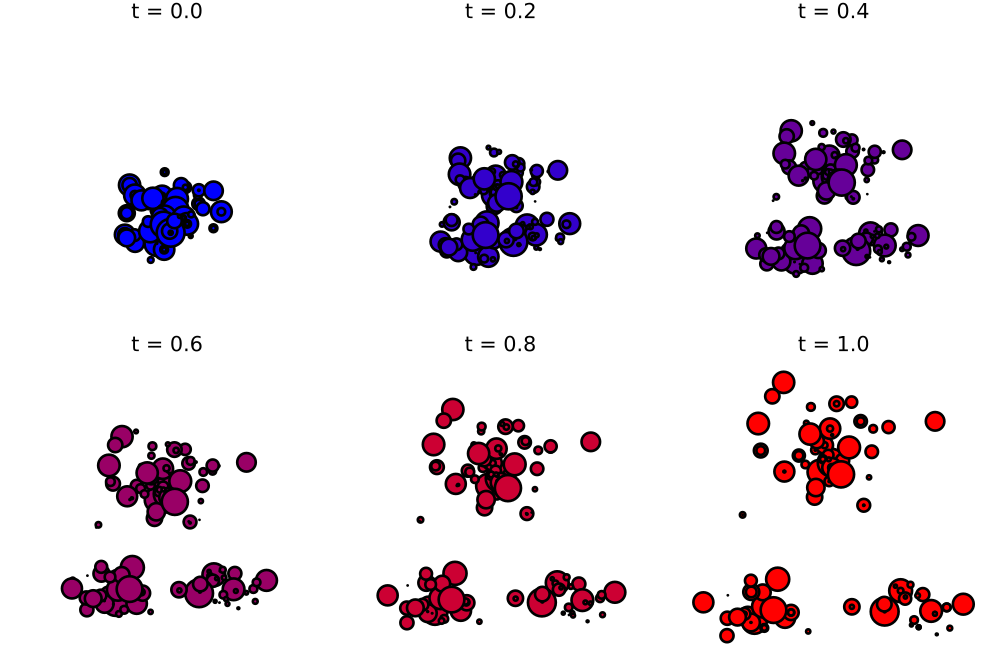

In [ ]:
plt = plot(layout=(2, 3), size=(1000, 666))
tlist = LinRange(0, 1, 6)
x_min, x_max = extrema(Y[1,:])
y_min, y_max = extrema(Y[2,:])
padding = 0.3
for (i, t) in enumerate(tlist)
    Xt = (1 - t) * X[:, I] + t * Y[:, J]
    myplot!(plt[i], Xt, Pij .* length(Pij) .* 0.5, RGBA.(t, 0, 1-t, 1) )
    xlims!(plt[i], x_min - padding, x_max + padding)
    ylims!(plt[i], y_min - padding, y_max + padding)
    plot!(plt[i], axis=nothing, border=:none, title="t = $(round(t, digits=1))")
end
display(plt)

Optimal Assignement
-------------------
In the case where $n = m$ and the weights are uniform, i.e., $a_i = 1/n$ and $b_j = 1/n$, one can show that there exists at least one optimal transport coupling that is a permutation matrix. This property arises from the fact that the extremal points of the transport polytope $U(1, 1)$ are permutation matrices.

This means there exists an optimal permutation $\sigma^\star \in \Sigma_n$ such that
$$
P^\star_{i,j} =
\begin{cases}
1 & \text{if } j = \sigma^\star(i), \\
0 & \text{otherwise}.
\end{cases}
$$

Here, $\Sigma_n$ denotes the set of all permutations (bijections) of $\{1, \ldots, n\}$.

This permutation solves the so-called *optimal assignment problem*:
$$
\sigma^\star \in \underset{\sigma \in \Sigma_n}{\arg\min}
\sum_{i=1}^n C_{i, \sigma(i)}.
$$

Use the same number of points.

In [ ]:
n = 40
m = n;

Compute points clouds.

In [ ]:
X, Y = generate_X_Y(n, m);

Constant distributions.

In [ ]:
a = ones(n)./n
b = a;

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [ ]:
C = distmat(X,Y);

Display the clouds.

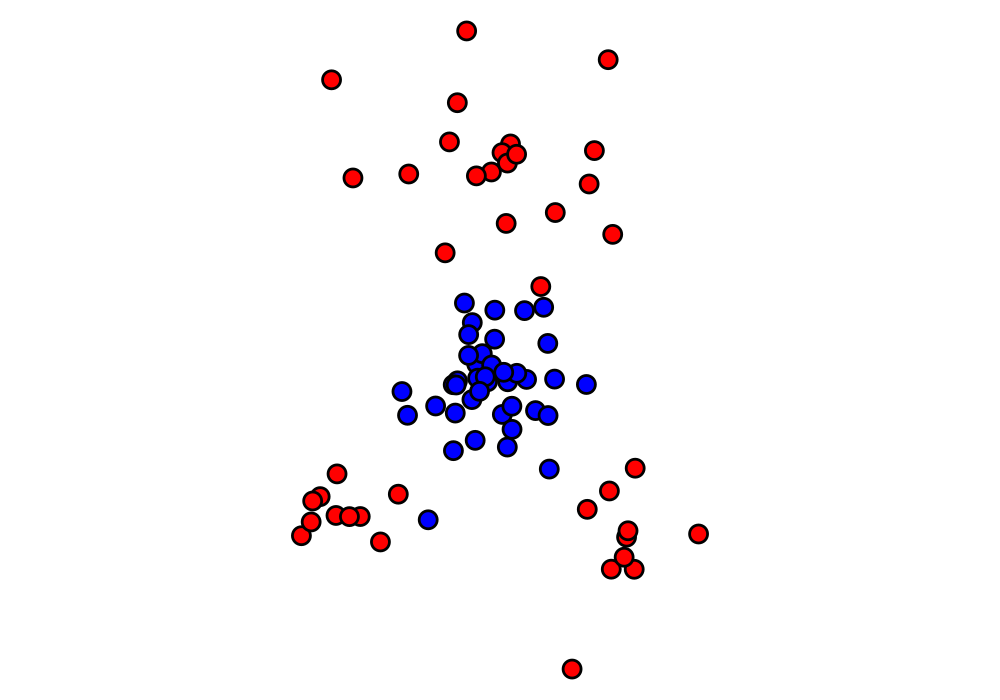

In [ ]:
plt = plot(size=(1000,700), aspect_ratio=:equal, axis=nothing, border=:none)
myplot!(plt, X, a .* length(a), :blue)
myplot!(plt, Y, b .* length(b), :red)

Solve the optimal transport.

In [ ]:
model = Model(HiGHS.Optimizer)
set_silent(model)
@variable(model, P[1:n, 1:m] >= 0)
@constraint(model, row_sums[i in 1:n], sum(P[i, j] for j in 1:m) == a[i])
@constraint(model, col_sums[j in 1:m], sum(P[i, j] for i in 1:n) == b[j])
@objective(model, Min, sum(P[i, j] * C[i, j] for i in 1:n, j in 1:m))
optimize!(model)
assert_is_solved_and_feasible(model)
P_value = value.(P);

Show that $P$ is a binary permutation matrix.

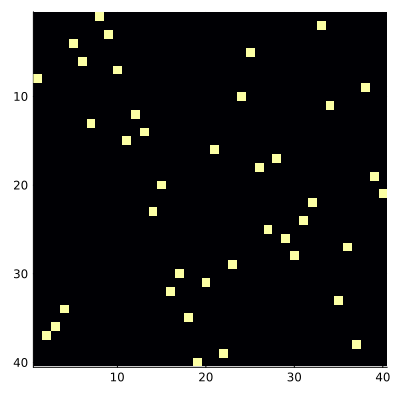

In [ ]:
heatmap(
    P_value,
    size=(400, 400),
    aspect_ratio=:equal,
    colorbar=false,
    yflip=true
)

Display the optimal assignment.

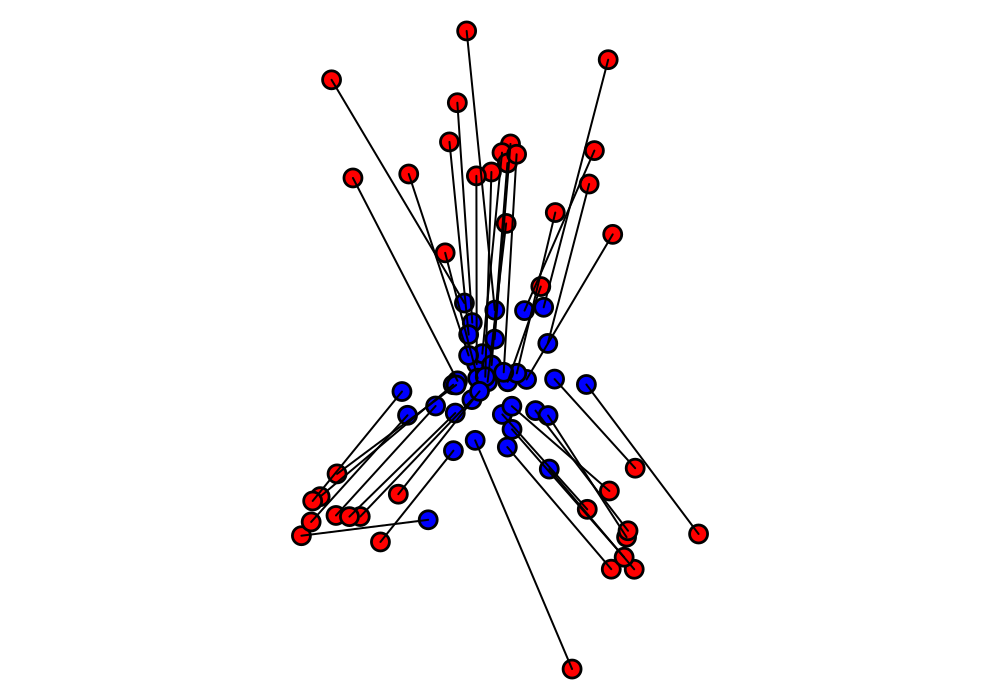

In [ ]:
plot_assignments(X, Y, a, b, P_value)